This notebook is for testing methods for performing a tidal analysis on the RIOPS currents.

Data
* RIOPS forecasts June 1-30, 2022, hourly frequency, surface currents (30 days)
* First 6 hours of every forecast is used (best esitmate)

Unfortuantely, we don't have hourly data for a continuous time series at the surface. I'm worried that compiling the best esitmate from the forecasts will results in an inaccruate tidal analysis

# Notes on tidal analysis
Using the six big resovable constituents, followng the 30-day analysis presented here: https://www.nature.com/articles/s41597-020-00578-z
* M2, N2, S2, K1, O1, Q1 

In [1]:
import pytides.constituent as constituent
my_consts = [
    constituent._M2, constituent._S2, constituent._N2, constituent._K1, constituent._O1, constituent._Q1, 
]

In [2]:
import glob
import os
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pytides.tide import Tide

In [3]:
plt.style.use('seaborn-talk')

In [4]:
data='/home/soontiensn/data/DenisLefaivre/riops/data/'

In [5]:
ufiles=glob.glob(os.path.join(data, '*VOZOCRTX*.nc'))
ufiles.sort()
du=xr.open_mfdataset(ufiles)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [6]:
du

<xarray.Dataset>
Dimensions:              (time: 720, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 30.56034 30.58307 ... 41.46735
    longitude            (yc, xc) float32 221.2824 221.31534 ... 20.87038
  * time                 (time) datetime64[ns] 2022-06-01 ... 2022-06-30T23:00:00
Data variables:
    polar_stereographic  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    vozocrtx             (time, yc, xc) float32 dask.array<shape=(720, 1610, 1770), chunksize=(1, 1610, 1770)>
Attributes:
    Conventions:      CF-1.6
    title:            Instantaneous sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Ocean Prediction System: version 2.2.0
    product_version:  RIOPS_2.2.0_F
    creation_

In [7]:

lons = du.longitude
lats = du.latitude

In [8]:
stations = {'Gulf': [1350,350],
            'NL': [1500,450],
            'Pacific': [400,400],
            'Arctic': [1100, 750]}

In [9]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
umean = du.vozocrtx.mean(dim='time').values
mesh=ax.pcolormesh(umean,vmin=-1,vmax=1,cmap='RdBu')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('u [m/s]')
for name in stations:
    i,j=stations[name]
    ax.plot(i,j, 'ko')
ax.set_title('RIOPS mean u velocity June  1-30, 2022')
fig.savefig('RIOPS-meanU-June2022.png')

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Plan
* Tidal analysis on U
* Find residule currents
* Power spectrum of residuls - is there energy at 6 hours? 

In [12]:
def tidal_analysis(speeds, times,  print_const=True, constituents=my_consts):
    demeaned = speeds - speeds.mean()
    dates=pd.to_datetime(times)
    if constituents:
        tide = Tide.decompose(demeaned,dates, constituents=my_consts)
    else:
        tide = Tide.decompose(demeaned,dates,)
    
    #print constituents
    constituent = [c.name for c in tide.model['constituent']]
    df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
    if print_const:
        display(df.sort_values('amplitude', ascending=False))

    
    #tidal prediction
    hours = np.cumsum(np.r_[0, [t.total_seconds() / 3600.0
                            for t in np.diff(dates.to_pydatetime())]])
    times = Tide._times(dates[0], hours)
    prediction = pd.Series(tide.at(times) + speeds.mean(), index=dates)
    
    return tide, prediction

In [13]:
def analyze_station(name):
    i,j = stations[name]
    uts = du.isel(xc=i,yc=j).vozocrtx.values
    lon = du.isel(xc=i,yc=j).longitude.values
    lon = lon -360 if lon > 180 else lon
    lat = du.isel(xc=i,yc=j).latitude.values
    times = du.time.values
    tide, prediction = tidal_analysis(uts, times, constituents=my_consts)
    
    # plot current + predcition
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    ax.plot(times, uts, color='C0', label='u')
    ax.plot(times, prediction.values, color='k', label='tidal prediction')
    ax.set_ylim([-.7,.7])
    ax.set_xlim(datetime(2022,6,1), datetime(2022,7,1))
    ax.legend()
    ax.grid()
    ax.set_title(f'{name}: [{lon:.2f}, {lat:.2f}]')
    ax.set_ylabel('[m/s]')
    fig.savefig(f'{name}-prediction-June2022.png', bbox_inches='tight')
    
    # plot residual + power spectrum
    residual=uts-prediction
    fig,axs=plt.subplots(2,1,figsize=(15,12))
    ax=axs[0]
    ax.plot(times, residual)
    ax.set_xlim(datetime(2022,6,1), datetime(2022,7,1))
    ax.grid()
    ax.set_title(f'{name} residual current')
    ax.set_ylabel('[m/s]')
    
    # power spectrum
    ax=axs[1]
    freqs = np.fft.fftfreq(residual.values.size, 1/24)
    idx = np.argsort(freqs)
    psd = np.abs(np.fft.fft(residual.values))**2
    ax.plot(freqs[idx], psd[idx], label='__nolegend__')
    m=psd.max()
    # K1
    ax.plot(24*np.array([1/23.93, 1/23.93]), [0,m], 'r--', lw=3,label='K1',zorder=0)
    # M2
    ax.plot(24*np.array([1/12.42, 1/12.42]), [0,m], 'b--', lw=3, label='M2',zorder=0)
    # 6 hours
    ax.plot(24*np.array([1/(6.), 1/(6.)]), [0,m], 'g--', lw=3, label='6 hours',zorder=0)
    ax.legend()
    ax.set_xlim([0,freqs.max()])
    ax.grid()
    ax.set_xlabel('Frequency (cycles/day)')
    ax.set_ylabel('Power spectrum of residual')
    fig.savefig(f'{name}-residual-June2022.png', bbox_inches='tight')

amplitude       phase
M2  2.442457e-01  357.885215
N2  7.829608e-02  328.813537
S2  5.206174e-02   24.712545
K1  3.898997e-02   74.956138
O1  2.698419e-02  344.769305
Q1  2.430597e-03  273.758352
Z0  2.251731e-08    0.000000

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


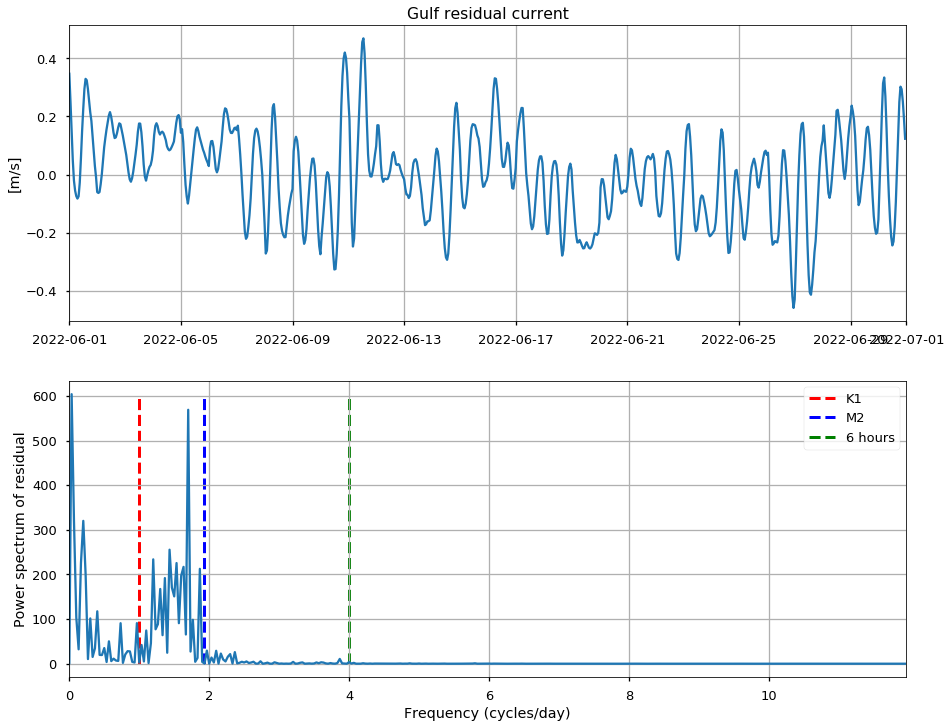

In [14]:
analyze_station('Gulf')

amplitude       phase
K1  2.016192e-02  274.869923
M2  1.508466e-02  324.203963
S2  7.873018e-03   47.386192
N2  3.955369e-03   30.402093
O1  3.666075e-03  305.053030
Q1  2.662764e-03  181.756069
Z0  1.324548e-09    0.000000

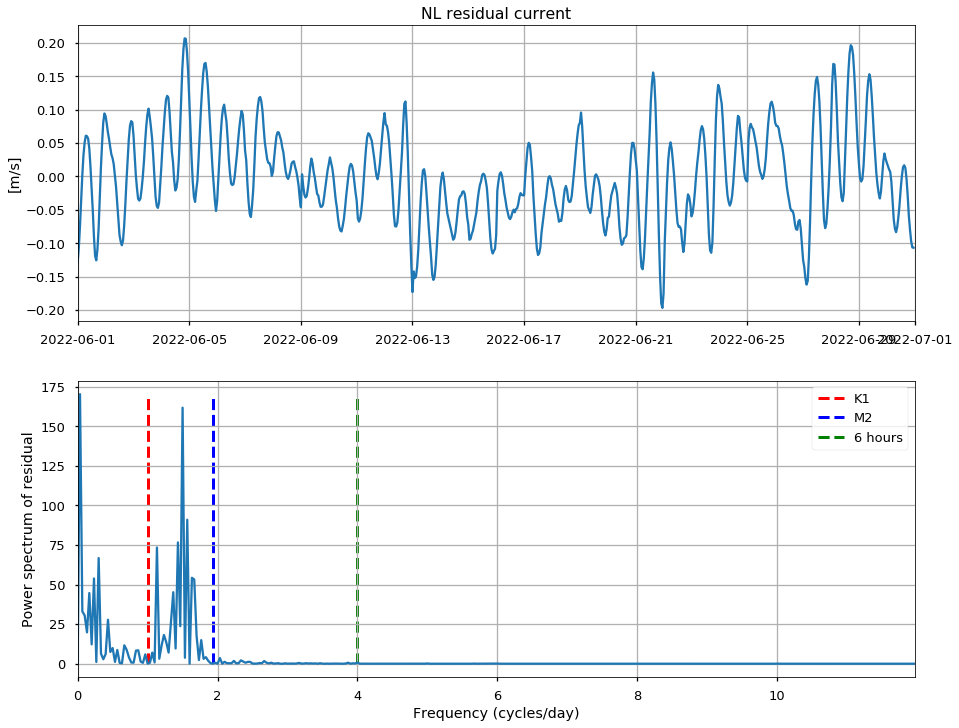

In [15]:
analyze_station('NL')

amplitude       phase
M2  5.535824e-02  219.394146
K1  2.497417e-02  347.485487
S2  1.760652e-02  244.180524
N2  1.523493e-02  204.370415
O1  4.206224e-03  349.249307
Q1  1.066915e-03  204.009926
Z0  1.655685e-09  180.000000

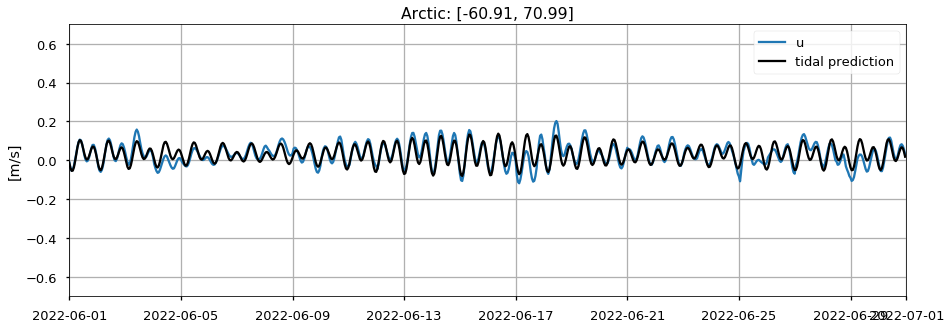

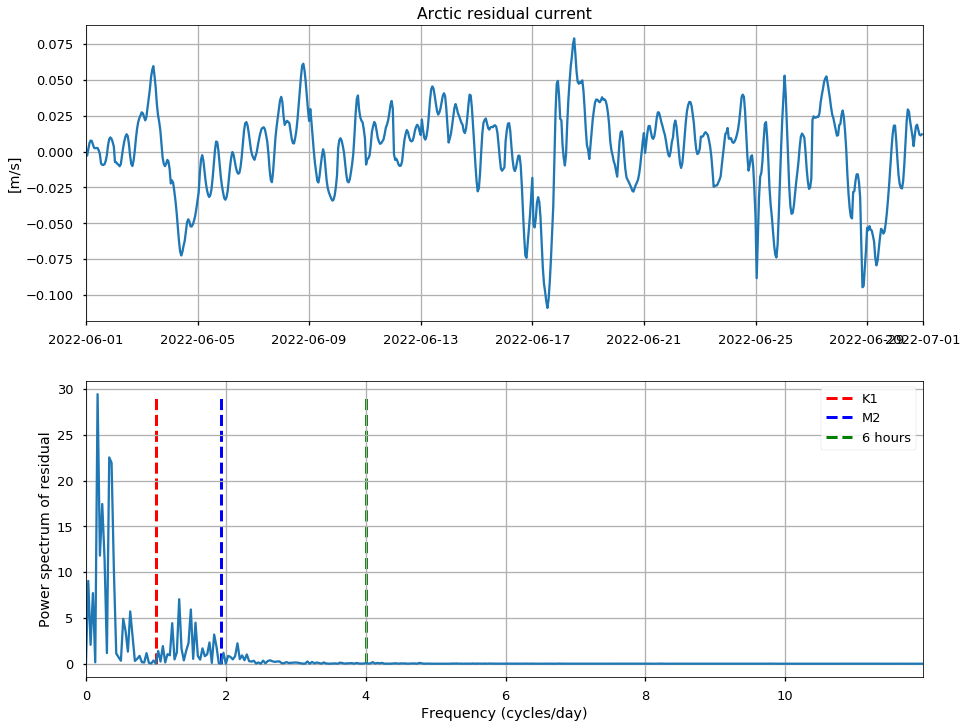

In [16]:
analyze_station('Arctic')

amplitude       phase
M2   0.041653  128.593943
N2   0.018927  148.149991
K1   0.012644  143.028251
S2   0.005850  141.646883
Q1   0.004851   11.405714
O1   0.001137  204.115907
Z0   0.000000    0.000000

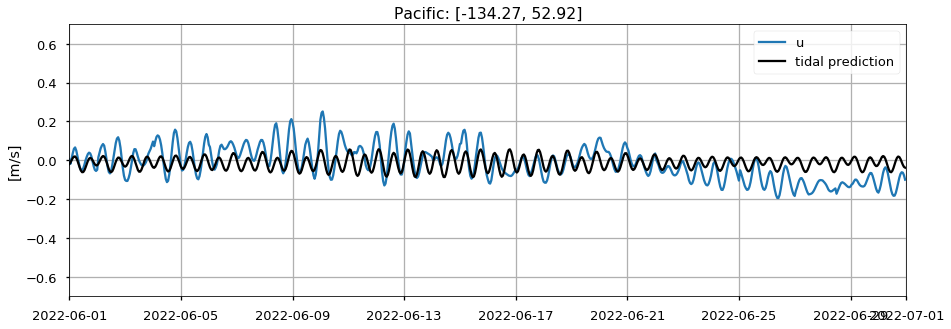

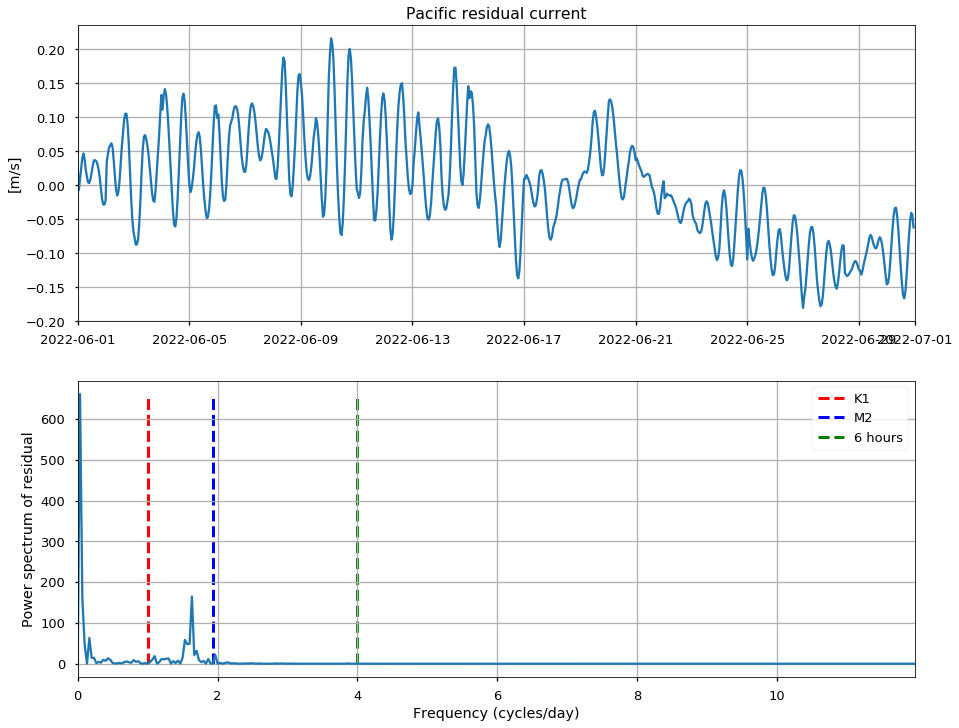

In [17]:
analyze_station('Pacific')